In [22]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [23]:

# Get the list of S&P 500 constituents
tickers = pd.read_excel(
    "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",
    header=4).Ticker.dropna().to_list()

# Retrieve historical data
df = yf.download(tickers, period='10y')
sp500 = df['Adj Close'].dropna(how='all', axis=1)


[*********************100%%**********************]  504 of 504 completed


3 Failed downloads:
['-', 'BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')


In [24]:
# Function to get lagged start and end periods
def get_lagged_periods(time_period):
    start_period = -20 - time_period
    end_period = -20  # latest data entry
    return start_period, end_period

In [25]:
#I think I can use this instead. I keep both for now
time_period = 1260  # 1 year 252, 5 year 1260 
start_period = -20 - time_period
end_period = -20  

In [26]:

# Function to calculate momentum factors
def calculate_momentum_factors(tickers, time_period):
    start_period, end_period = get_lagged_periods(time_period)

    # Calculating 52 Week trend
    """First parameter of polyfit takes the length of the slice of data we are using
    Second parameter takes the closed prices of the same slice of data. X and Y relationship.
    """
    lagged_closed_price = sp500[start_period:end_period]
    polyfit_regression = np.polyfit(range(len(lagged_closed_price)), lagged_closed_price, 1) 
    slope_info = pd.DataFrame(polyfit_regression) # Convert so that we can use the results
    slope_info.columns = sp500.columns # Setting column names to match ticker
    _52_week_trend= slope_info.iloc[0] # Only need first row 


    # Percent above 260 day Low
    percent_above_260 = (lagged_closed_price - lagged_closed_price.rolling(window=260).min()) / lagged_closed_price.rolling(window=260).min() * 100
    percent_above_260 = percent_above_260.dropna(how='all').mean()

    # Oscillator calculations
    oscillator = (lagged_closed_price.rolling(window=4).mean() - lagged_closed_price.rolling(window=52*5).mean()) / lagged_closed_price.rolling(window=52*5).mean() * 100
    oscillator = oscillator.dropna(how='all').mean()    

    # 39 week returns
    _39_week_return = lagged_closed_price.pct_change(periods=39*5)
    _39_week_return= _39_week_return.dropna(how='all').mean()    

    # Volume Price Trend
    volume = df['Volume'].dropna(how='all', axis=1)
    weekly_means = sp500[start_period:end_period].rolling(5).mean()
    weekly_volume = volume[start_period:end_period].rolling(5).mean()
    volume_price_trend = (weekly_means.pct_change() * weekly_volume).sum()
    

    # Creating the DataFrame
    new_table = pd.DataFrame(index=sp500.transpose().index)
    new_table['Slope 52 Week Trend-Line'] = _52_week_trend
    new_table['Percent above 260 Day Low'] = percent_above_260
    new_table['4/52 Week Oscillator'] = oscillator
    new_table['39_Week_Return'] = _39_week_return
    new_table['51 Week Volume Price Trend'] = volume_price_trend

    return new_table



In [27]:
momentum_factors = calculate_momentum_factors(tickers, time_period)
momentum_factors



,Slope 52 Week Trend-Line,Percent above 260,4/52 Week Oscillator,39_Week_Return,51 Week Volume Price Trend
A,0.063805,38.422967,7.604491,0.137755,-1.723091e+03
AAL,-0.014251,44.142864,-7.301515,-0.051442,7.391174e+07
AAPL,0.121493,60.742505,17.103673,0.314515,8.685561e+07
ABBV,0.086764,40.583355,11.431609,0.174754,1.138119e+06
ABNB,NaN,32.356081,-6.721011,-0.049235,-1.506849e+06
...,...,...,...,...,...
YUM,0.038298,36.528105,3.639218,0.081954,2.260298e+05
ZBH,0.002870,35.165584,0.628165,0.043030,-9.233132e+05
ZBRA,0.110112,58.224422,5.336694,0.151967,-3.794557e+05
ZION,0.005692,52.351234,-0.613149,0.032871,-6.577285e+06


In [28]:
z_scores = (momentum_factors - momentum_factors.mean()) / momentum_factors.std()
z_scores = z_scores.sum(axis=1)



In [29]:
z_scores.sort_values(ascending=True, inplace= True)
long_basket= z_scores[-10:]
short_basket = z_scores[:10]

print("Long Basket:", long_basket)
print("Short Basket:", short_basket)


Long Basket: FCX      8.144236
SEDG     8.183473
CMG      9.711885
AMD     10.447449
AZO     10.718983
NVR     14.879294
NVDA    15.854758
ENPH    19.516492
MRNA    20.295090
TSLA    43.556170
dtype: float64
Short Basket: VFC    -7.606430
VTRS   -6.632330
WBD    -6.256357
FIS    -6.131708
PARA   -6.043903
BAX    -5.947741
WBA    -5.611515
MMM    -5.282357
BXP    -5.222004
VZ     -5.199327
dtype: float64


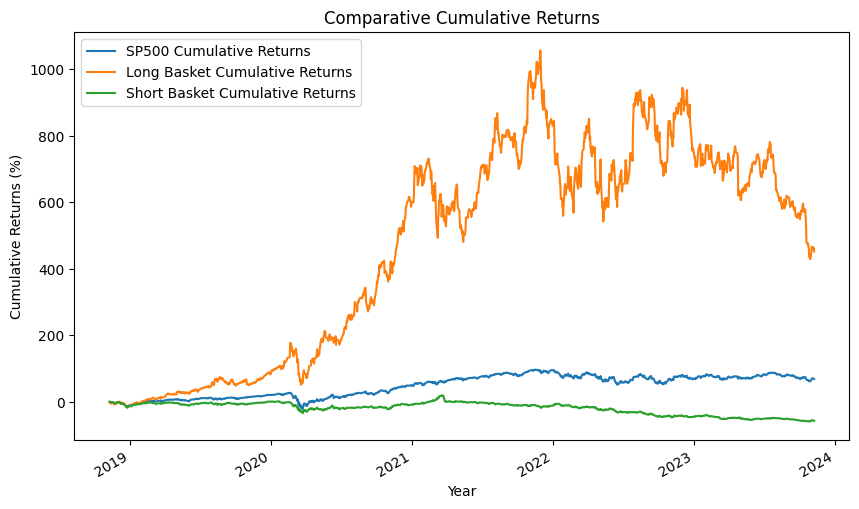

In [47]:
#Back-Test period of time_period year (20 Day Lag)

long_list =long_basket.index
short_list= short_basket.index

long_basket_close =sp500[start_period:end_period][long_list]
short_basket_close =sp500[start_period:end_period][short_list]


# I should make this next part a function, for autonomy
returns = sp500[start_period:end_period].pct_change()
cumulative_returns = (((1 + returns).cumprod()-1)*100).mean(axis=1)


long_returns = long_basket_close.pct_change()
long_cumulative_returns = (((1+long_returns).cumprod()-1)*100).mean(axis=1)

short_returns = short_basket_close.pct_change()
short_cumulative_returns = (((1+short_returns).cumprod()-1)*100).mean(axis=1)



plt.figure(figsize=(10,6))
cumulative_returns.plot(label='SP500 Cumulative Returns')
long_cumulative_returns.plot(label='Long Basket Cumulative Returns')
short_cumulative_returns.plot(label='Short Basket Cumulative Returns')

plt.legend()
plt.title('Comparative Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()




# There is an issue with the way I'm graphing cumulative returns. The spread gets bigger as time increases.
